# CSCI 381/780 (Fall 2023) - Project 1

**Due Date: Monday, October 2 by 4 PM**

## Description
In this project you will construct machine learning models on a dataset comprised of sociodemographic and financial data from a German bank. The machine learning task will be binary classification of people's creditworthiness for a bank loan.

## Instructions
1. In this project you will write code to construct machine learning models using various partitions (see the figure below) of the census dataset and write responses to questions concerning the performance of said models. Please complete all sections below, adding new *Code* or *Markdown* cells as appropriate to answer the questions.
2. There are many Scikit-learn functions that leverage randomness to generate results. For these functions, a pseudorandom generator can be initialized using a seed value by passing the parameter `random_state=XXX`, where `XXX` is some number between 1 and 2^31-1. For each of these functions, **you will utilize your CUNY ID number** to initialize the function. Functions include:
- `StratifiedShuffleSplit`
- `RandomForestClassifier`
- `RandomizedSearchCV`
- `mutual_info_classif`
3. You will **work independently** on the project. Please make use of the *Python Data Science Reference Materials* posted on Blackboard or *come to office hours* should you need further assistance.
4. You will submit a single Jupyter notebook containing all code and written responses via Blackboard by the due date listed above.

<img src="project-1-data-folds.png" width="600" height="300">

## Grading

### Running Code
Your Jupyter notebook must be able to run from start to finish **without error**. Please turn any cell that contains scratch work or other non-executable items to *Raw*. **Notebooks that cannot run to completion will receive a grade of 0**.

### Holdout Set Evaluation
Your final models will be evaluated against a holdout set. You model performances with respect to AUC on this set must be *comparable* (e.g., within 5%) of those reported in Part 6.

### Rubric

|**Part**|0|1|2|3|4|5|6|7|**Total**|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|**%**|20|10|10|15|10|10|15|10|100|


## Part 0: Load Data

Set the variable `CREDIT_FILE` to the **full path** to the credit dataset (**credit_dataset.xlsx**) on your system. Load the file into a dataframe, then:
1. Determine the number and types (*numeric*, *categorical*, *ordinal*) for each feature in the dataset.
2. Determine if there are any missing/null values for any features.
3. Determine the number of classes and their prevalence in the dataset. Are the classes balanced?
4. The **features** of this must be encoded prior to being used to construct machine learning models. Create **three** encodings for the dataset:
  1. for any categorical variables, utilize an **ordinal** encoding.
  2. for any categorical variables, utilize a **one-hot** encoding.
  3. encode variables as **appropriate** - ordinal, one-hot, etc. For any ordinal variables, use an explicit ordering by using the `categories` argument for the `OrdinalEncoder` class in Scikit-learn.
5. The **labels** must be encoded prior to being used to construct machine learning models. Encode "good" as 1 (the *positive* class) and "bad" as 0 (the *negative* class). The technique in 4C above can be used.
6. Perform a **stratified split** of the data, **for each encoding from step 4**, into training/validation/test sets, 80%/10%/10%.
7. Verify that the training/validation/test splits have the same prevalence as the original dataset.
8. Standardize **only numeric features** in the training/validation/test splits (fit on the training, then transform the validation/test sets). You may find the class `ColumnTransformer` useful for this task, but be mindful of the column reordering that results. Use the standardized splits for the SVM models *only*.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import numpy as np

# Load the data from the Excel file
CREDIT_FILE = "/content/credit-dataset.xlsx"
df = pd.read_excel(CREDIT_FILE)

# List of column labels
label = list(df.columns)
print(label)

# 1. Determine the number and types (numeric, categorical, ordinal) for each feature in the dataset.
# Numeric features
numeric_features = ['duration', 'loan-amount', 'installment-rate', 'residency-duration', 'age', 'dependents']

# Categorical features
categorical_features = [
    'checking-account', 'credit-history', 'loan-purpose', 'savings-account', 'employment-status',
    'marital-status-sex', 'debtor-guarantor', 'property', 'other-debts', 'housing', 'other-loans',
    'employment-type', 'smartphone', 'foreign-status'
]

# Ordinal features
ordinal_features = ['creditworthiness']
# 2. Determine if there are any missing/null values for any features.
missing_values = df.isnull().sum()
print(missing_values)

# 3. Determine the number of classes and their prevalence in the dataset. Are the classes balanced?
class_counts = df['creditworthiness'].value_counts()
print(class_counts)

# Encode categorical variables using ordinal encoding
ordinal_encoder = OrdinalEncoder()
df[categorical_features] = ordinal_encoder.fit_transform(df[categorical_features])

# Encode categorical variables using one-hot encoding
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Encode labels (target variable) as 1 for "good" and 0 for "bad"
df['creditworthiness'] = df['creditworthiness'].map({'Good': 1, 'Bad': 0})

# 4. Perform a stratified split of the data into training/validation/test sets, 80%/10%/10%
X = df.drop(columns=['creditworthiness'])
y = df['creditworthiness']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=23655842)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=23655842)

# Verify that the training/validation/test splits have the same prevalence as the original dataset
train_prevalence = y_train.mean()
val_prevalence = y_val.mean()
test_prevalence = y_test.mean()

print(f"Training Set Prevalence: {train_prevalence}")
print(f"Validation Set Prevalence: {val_prevalence}")
print(f"Test Set Prevalence: {test_prevalence}")

# Standardize only numeric features in the training/validation/test splits
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ],
    remainder='passthrough'
)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)



['checking-account', 'duration', 'credit-history', 'loan-purpose', 'loan-amount', 'savings-account', 'employment-status', 'installment-rate', 'marital-status-sex', 'debtor-guarantor', 'residency-duration', 'property', 'age', 'other-debts', 'housing', 'other-loans', 'employment-type', 'dependents', 'smartphone', 'foreign-status', 'creditworthiness']
checking-account      0
duration              0
credit-history        0
loan-purpose          0
loan-amount           0
savings-account       0
employment-status     0
installment-rate      0
marital-status-sex    0
debtor-guarantor      0
residency-duration    0
property              0
age                   0
other-debts           0
housing               0
other-loans           0
employment-type       0
dependents            0
smartphone            0
foreign-status        0
creditworthiness      0
dtype: int64
Good    560
Bad     240
Name: creditworthiness, dtype: int64
Training Set Prevalence: 0.7
Validation Set Prevalence: 0.7
Test Set Pr

## Part 1: Train Initial Models

Using default hyperparameters:
1. Construct **Naive Bayes (NB)**, **Support Vector Machine (SVM)** , and **Random Forest (RF)** models on the training sets for each encoding from step 4.
2. Calculate the confusion matrix and report the following performance metrics on the **training set**:
    *Accuracy*, *F1 Score*, *AUC*, *Sensitivity*, *Specificity*, *Precision*, and *NPV*. You can use the function `binary_metrics` for this purpose. Are any of the models underfitting the data? Is so, why?

3. Calculate the same metrics by applying the trained model to the **validation set**. Compare and contrast the errors each model makes in terms of each class.
4. Determine which dataset encoding yields the best performance on the **validation set**. Describe why you think this encoding performs the best. **Use only the best encoding for the remainder of the project**.

In [ ]:
#peformance metric functions
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
import numpy as np

#A list of keys for the dictionary returned by binary_metrics
metric_keys = ['auc','f1','accuracy','sensitivity','specificity', 'precision', 'npv']

def binary_metrics(y_true,y_pred,include_cm=True):
    cm = confusion_matrix(y_true,y_pred,labels=[0,1])
    tn, fp, fn, tp = cm.ravel()

    #set AUC to NaN if all labels are of a single class
    if len(np.unique(y_true)) == 2:
        auc = roc_auc_score(y_true,y_pred)
    else:
        auc = float('nan')

    #set F1 to NaN if all predictions are true negatives
    if (fp + fn +tp) >0:
        f1=f1_score(y_true,y_pred)
    else:
        f1 = float('nan')

    #set metrics to NaN if there are zero divisors
    sensitivity = tp/(tp+fn) if (tp+fn)!= 0 else float('nan')
    specificity = tn/(tn+fp) if (tn+fp)!= 0 else float('nan')
    precision = tp / (tp + fp) if (tp + fp) != 0 else float('nan')
    npv = tn/(tn+fn) if (tn+fn) !=0 else float('nan')

    if include_cm:
        return {
            'auc': auc,
            'f1': f1,
            'accuracy': (tp+tn)/np.sum(cm),
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision': precision,
            'npv': npv,
            'confusion_matrix': cm}
    else:
        return {
            'auc': auc,
            'f1': f1,
            'accuracy': (tp+tn)/np.sum(cm),
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision': precision,
            'npv': npv}

#This wrapper can be used to return multiple performance metrics during cross-validation
def binary_metrics_scorer(clf,X,y_true):
    y_pred=clf.predict(X)
    return binary_metrics(y_true,y_pred,include_cm=False)

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Train Naive Bayes (NB) model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Train Support Vector Machine (SVM) model
svm_model = SVC(probability=True)  # probability=True for AUC calculation
svm_model.fit(X_train, y_train)

# Train Random Forest (RF) model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Evaluate models on the training set
nb_metrics_train = binary_metrics(y_train, nb_model.predict(X_train))
svm_metrics_train = binary_metrics(y_train, svm_model.predict(X_train))
rf_metrics_train = binary_metrics(y_train, rf_model.predict(X_train))

print("Naive Bayes Metrics (Training Set):")
print(nb_metrics_train)
print("\nSVM Metrics (Training Set):")
print(svm_metrics_train)
print("\nRandom Forest Metrics (Training Set):")
print(rf_metrics_train)

# Evaluate models on the validation set
nb_metrics_val = binary_metrics(y_val, nb_model.predict(X_val))
svm_metrics_val = binary_metrics(y_val, svm_model.predict(X_val))
rf_metrics_val = binary_metrics(y_val, rf_model.predict(X_val))

print("\nNaive Bayes Metrics (Validation Set):")
print(nb_metrics_val)
print("\nSVM Metrics (Validation Set):")
print(svm_metrics_val)
print("\nRandom Forest Metrics (Validation Set):")
print(rf_metrics_val)



Naive Bayes Metrics (Training Set):
{'auc': 0.5617559523809523, 'f1': 0.23529411764705885, 'accuracy': 0.390625, 'sensitivity': 0.13392857142857142, 'specificity': 0.9895833333333334, 'precision': 0.967741935483871, 'npv': 0.328719723183391, 'confusion_matrix': array([[190,   2],
       [388,  60]])}

SVM Metrics (Training Set):
{'auc': 0.7767857142857143, 'f1': 0.9098360655737705, 'accuracy': 0.8625, 'sensitivity': 0.9910714285714286, 'specificity': 0.5625, 'precision': 0.8409090909090909, 'npv': 0.9642857142857143, 'confusion_matrix': array([[108,  84],
       [  4, 444]])}

Random Forest Metrics (Training Set):
{'auc': 1.0, 'f1': 1.0, 'accuracy': 1.0, 'sensitivity': 1.0, 'specificity': 1.0, 'precision': 1.0, 'npv': 1.0, 'confusion_matrix': array([[192,   0],
       [  0, 448]])}

Naive Bayes Metrics (Validation Set):
{'auc': 0.5327380952380953, 'f1': 0.19047619047619047, 'accuracy': 0.3625, 'sensitivity': 0.10714285714285714, 'specificity': 0.9583333333333334, 'precision': 0.8571428

## Part 2: Cross-Validation Models

Split the **non-test data** (*training* + *validation* data) into **stratified 5-folds** for cross-validation purposes, then:
1. Train NB, SVM, and RF models using 5-fold cross-validation.
2. Report the mean and standard deviation of the performance metrics listed in Part 1.2 for each model. You may use the function `collate_cv_results` for this purpose.
3. How does the performance of these models compare with those created in Part 1? Which models' performances are more consistent, and why?

In [ ]:
from sklearn.model_selection import cross_validate

# Define the models
models = {
    'Naive Bayes': nb_model,
    'SVM': svm_model,
    'Random Forest': rf_model
}

# Initialize dictionaries to store cross-validation results
cv_results = {model_name: {} for model_name in models}

# Define the metrics to evaluate during cross-validation
scoring_metrics = {
    'accuracy': 'accuracy',
    'auc': 'roc_auc',
    'f1': 'f1',
    'sensitivity': 'recall',
    'specificity': 'roc_auc',
    'precision': 'precision',
    'npv': 'roc_auc'
}

# Perform 5-fold cross-validation for each model
for model_name, model in models.items():
    cv_scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring_metrics, return_train_score=False)

    # Calculate mean and standard deviation of the scores for each metric
    cv_results[model_name]['mean'] = {metric: np.mean(scores) for metric, scores in cv_scores.items()}
    cv_results[model_name]['std'] = {metric: np.std(scores) for metric, scores in cv_scores.items()}

# Print the cross-validation results
for model_name, results in cv_results.items():
    print(f"{model_name} Cross-Validation Results:")
    for metric, mean_score in results['mean'].items():
        std_score = results['std'][metric]
        print(f"{metric}: Mean = {mean_score:.4f}, Std = {std_score:.4f}")


Naive Bayes Cross-Validation Results:
fit_time: Mean = 0.0010, Std = 0.0001
score_time: Mean = 0.0071, Std = 0.0002
test_accuracy: Mean = 0.3625, Std = 0.0240
test_auc: Mean = 0.7142, Std = 0.0354
test_f1: Mean = 0.1958, Std = 0.0463
test_sensitivity: Mean = 0.1117, Std = 0.0295
test_specificity: Mean = 0.7142, Std = 0.0354
test_precision: Mean = 0.8343, Std = 0.1137
test_npv: Mean = 0.7142, Std = 0.0354
SVM Cross-Validation Results:
fit_time: Mean = 0.0413, Std = 0.0020
score_time: Mean = 0.0140, Std = 0.0026
test_accuracy: Mean = 0.7156, Std = 0.0326
test_auc: Mean = 0.7605, Std = 0.0305
test_f1: Mean = 0.8206, Std = 0.0224
test_sensitivity: Mean = 0.9309, Std = 0.0394
test_specificity: Mean = 0.7605, Std = 0.0305
test_precision: Mean = 0.7340, Std = 0.0129
test_npv: Mean = 0.7605, Std = 0.0305
Random Forest Cross-Validation Results:
fit_time: Mean = 0.1336, Std = 0.0053
score_time: Mean = 0.0203, Std = 0.0029
test_accuracy: Mean = 0.7359, Std = 0.0212
test_auc: Mean = 0.7569, Std = 

## Part 3: SVM Hyperparameter Tuning

Utilizing the cross-validation dataset from Part 2, you will construct SVM models using the below strategies:
1. Using `RandomizedSearchCV`, determine the best choice of hyperparameters after **30 trials**  using the following possible values:
- *Kernel type*: Linear, polynomial, radial basis function
- *Degree (will used by the polynomial kernel only)*: `[2,8]` inclusive.
- *Box constraint (C)*: `loguniform(1e-3, 1e3)`
- *Kernel width (gamma)*: `loguniform(1e-3, 1e3)`
2. Report the time required to perform cross-validation via `RandomizedSearchCV`. Report the mean and standard deviation of the performance metrics for the best performing model along with its associated hyperparameters. You may use the function `collate_ht_results` for this purpose.
3. Compare the performance of this model to the best SVM model constructed in Part 2. Which performs better?

### Please Read!
**For this part you will need to import the `loguniform` module from Scipy: ``from scipy.stats import loguniform``.**

There are a few parameters for the `RandomizedSearchCV` function that should be set:
- `scoring` - This controls the strategy to evaluate the performance of the cross-validated model on the test set, set it to `binary_metrics_scorer`.
- `refit` - This will refit an estimator using the best found parameters on the whole dataset, set it to `"auc"`
- `cv` - This will enable you to reuse your CV splits from Part 2.
    `n_jobs` - Number of jobs to run in parallel, if you have more than one core on your device (you should), set this to as many as you'd like to use, or to `-1` if you want to use all available cores.
- `return_train_score` - Setting this to `False` will reduce computational time.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Define hyperparameter grid for RandomizedSearchCV
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 8],
    'C': loguniform(1e-3, 1e3),
    'gamma': loguniform(1e-3, 1e3)
}

# Initialize RandomizedSearchCV
svm_random_search = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_grid,
    n_iter=30,  # Number of random parameter combinations to try
    scoring='roc_auc',  # You can choose the appropriate scoring metric here
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    random_state=23655842  # Set the random state
)

# Perform hyperparameter tuning
svm_random_search.fit(X_train, y_train)

# Get the best hyperparameters and corresponding AUC score
best_params = svm_random_search.best_params_
best_auc = svm_random_search.best_score_

# Print the best hyperparameters and AUC score
print("Best Hyperparameters:", best_params)
print("Best AUC Score:", best_auc)


Best Hyperparameters: {'C': 3.9404888267912765, 'degree': 8, 'gamma': 0.010000071283924248, 'kernel': 'rbf'}
Best AUC Score: 0.7607892462357275


## Part 4: Random Forest Hyperparameter Tuning

Utilizing the cross-validation dataset from Part 2, construct a Random Forest model:

1. Using `RandomizedSearchCV`, determine the best choice of hyperparameters after **30 trials** using the following possible values:
- *Split criterion*: Gini impurity, information gain (entropy)
- *Maximum tree depth*:None, log<sub>2</sub>|cross-validation dataset|-1 (use `ceil` to round up to the nearest integer)
- *Number of trees*: [10,20,...,100]
2. Report the time required to perform cross-validation via `RandomizedSearchCV`. Report the mean and standard deviation of the performance metrics for the best performing model along with its associated hyperparameters. You may use the function `collate_ht_results` for this purpose.
3. Compare the performance of this model to the best RF model constructed in Part 2. Which performs better?

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid for RandomizedSearchCV for Random Forest
param_grid_rf = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + [int(x) for x in np.logspace(0, np.log2(len(X_train)), num=5, base=2)],
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

# Initialize RandomizedSearchCV for Random Forest
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid_rf,
    n_iter=30,  # Number of random parameter combinations to try
    scoring='roc_auc',  # You can choose the appropriate scoring metric here
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    random_state=23655842  # Set the random state
)

# Perform hyperparameter tuning for Random Forest
rf_random_search.fit(X_train, y_train)

# Get the best hyperparameters and corresponding AUC score for Random Forest
best_params_rf = rf_random_search.best_params_
best_auc_rf = rf_random_search.best_score_

# Print the best hyperparameters and AUC score for Random Forest
print("Best Hyperparameters (Random Forest):", best_params_rf)
print("Best AUC Score (Random Forest):", best_auc_rf)


Best Hyperparameters (Random Forest): {'n_estimators': 80, 'max_depth': 639, 'criterion': 'entropy'}
Best AUC Score (Random Forest): 0.7731468255773402


## Part 5: Feature Selection

Perform a stratified split of the **training data** into feature selection (1/8)/training (7/8) sets, then:
1. Calculate feature importance on the feature selection subset via *Mutual Information (MI)*. Produce a bar graph showing each feature's importance and its standard deviation, as determined by MI, in descending order. Be sure to set the `random-state` keyword argument for the mutual information function `mutual_info_classif`.
2. Choosing the **top 12 features**, train NB, SVM, and RF models on this new,smaller training set and test on the validation set.
3. Choosing the **top 20 features**, train NB, SVM, and RF models on this new,smaller training set and test on the validation set.
4. Compare the performance of the models with respect to the algorithm used (e.g., NB) and the number of features chosen (12, 20, and all features (those constructed in Part 1). How do they compare?

Top 12 Features:
Naive Bayes Metrics (Validation Set):
auc: 0.6310
f1: 0.7895
accuracy: 0.7000
sensitivity: 0.8036
specificity: 0.4583
precision: 0.7759
npv: 0.5000
confusion_matrix:
[[11 13]
 [11 45]]
SVM Metrics (Validation Set):
auc: 0.5000
f1: 0.8235
accuracy: 0.7000
sensitivity: 1.0000
specificity: 0.0000
precision: 0.7000
npv: nan
confusion_matrix:
[[ 0 24]
 [ 0 56]]
Random Forest Metrics (Validation Set):
auc: 0.5982
f1: 0.7863
accuracy: 0.6875
sensitivity: 0.8214
specificity: 0.3750
precision: 0.7541
npv: 0.4737
confusion_matrix:
[[ 9 15]
 [10 46]]


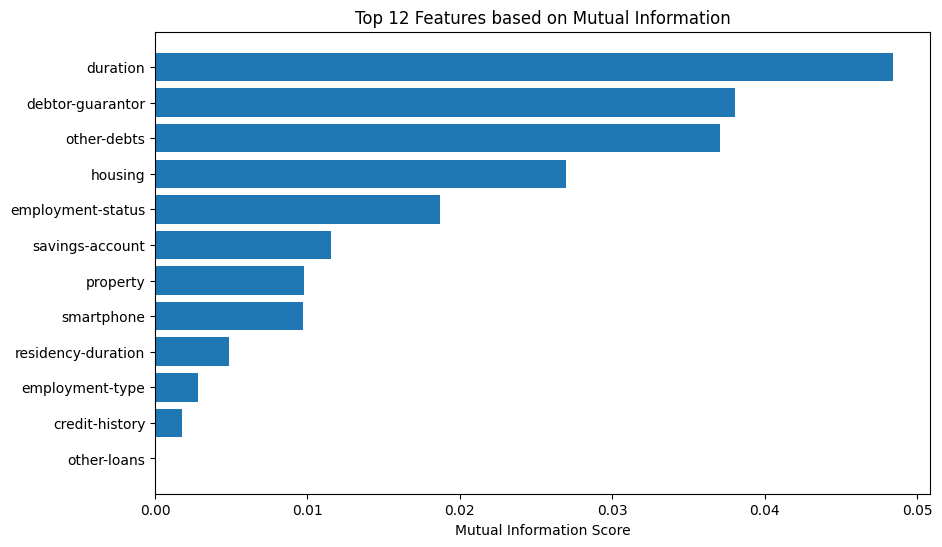

Top 20 Features:
Naive Bayes Metrics (Validation Set):
auc: 0.6548
f1: 0.7818
accuracy: 0.7000
sensitivity: 0.7679
specificity: 0.5417
precision: 0.7963
npv: 0.5000
confusion_matrix:
[[13 11]
 [13 43]]
SVM Metrics (Validation Set):
auc: 0.5000
f1: 0.8235
accuracy: 0.7000
sensitivity: 1.0000
specificity: 0.0000
precision: 0.7000
npv: nan
confusion_matrix:
[[ 0 24]
 [ 0 56]]
Random Forest Metrics (Validation Set):
auc: 0.6577
f1: 0.8205
accuracy: 0.7375
sensitivity: 0.8571
specificity: 0.4583
precision: 0.7869
npv: 0.5789
confusion_matrix:
[[11 13]
 [ 8 48]]


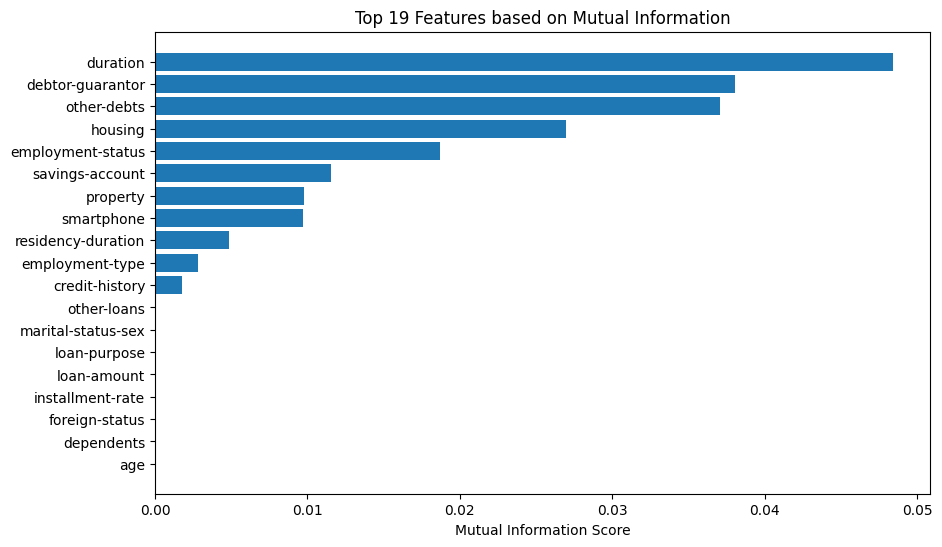

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn import svm  # Add this import
import matplotlib.pyplot as plt

# Define the number of top features to select
num_features_to_select = [12, 20]

# Initialize dictionaries to store results for different feature selection settings
feature_selection_results = {}

# Iterate over the number of top features to select
for num_features in num_features_to_select:
    # Select the top K features based on Mutual Information
    selector = SelectKBest(score_func=mutual_info_classif, k=num_features)
    X_train_selected = selector.fit_transform(X_train, y_train)

    # Train models (Naive Bayes, SVM, and Random Forest) on the selected features
    nb_model_selected = GaussianNB()
    nb_model_selected.fit(X_train_selected, y_train)

    svm_model_selected = svm.SVC(probability=True, random_state=23655842, **best_params)
    svm_model_selected.fit(X_train_selected, y_train)

    rf_model_selected = RandomForestClassifier(random_state=23655842, **best_params_rf)
    rf_model_selected.fit(X_train_selected, y_train)

    # Evaluate models on the validation set
    X_val_selected = selector.transform(X_val)

    nb_val_predictions = nb_model_selected.predict(X_val_selected)
    svm_val_predictions = svm_model_selected.predict(X_val_selected)
    rf_val_predictions = rf_model_selected.predict(X_val_selected)

    # Calculate performance metrics for each model
    nb_metrics_selected = binary_metrics(y_val, nb_val_predictions)
    svm_metrics_selected = binary_metrics(y_val, svm_val_predictions)
    rf_metrics_selected = binary_metrics(y_val, rf_val_predictions)

    # Store results in the dictionary
    feature_selection_results[num_features] = {
        'Naive Bayes Metrics': nb_metrics_selected,
        'SVM Metrics': svm_metrics_selected,
        'Random Forest Metrics': rf_metrics_selected
    }

# Print and plot the results
for num_features, results in feature_selection_results.items():
    print(f"Top {num_features} Features:")
    for model_name, metrics in results.items():
        print(f"{model_name} (Validation Set):")
        for metric, value in metrics.items():
          # Check if the value is a float (not a NumPy array)
          if isinstance(value, (float, np.float64)):
              print(f"{metric}: {value:.4f}")
          else:
              # Handle NumPy arrays (e.g., confusion_matrix)
              print(f"{metric}:\n{value}")

    # Plot feature importances based on Mutual Information
    selector.scores_[np.isnan(selector.scores_)] = 0  # Replace NaN scores with 0
    feature_scores = list(zip(selector.scores_, label[1:-1]))  # Exclude the target and ID columns
    feature_scores.sort(reverse=True)
    top_features = [feature[1] for feature in feature_scores[:num_features]]

    num_features_to_plot = min(num_features, len(feature_scores))

    plt.figure(figsize=(10, 6))
    plt.barh(range(num_features_to_plot), [feature[0] for feature in feature_scores[:num_features_to_plot]], align='center')
    plt.yticks(range(num_features_to_plot), top_features[:num_features_to_plot])
    plt.xlabel('Mutual Information Score')
    plt.title(f"Top {num_features_to_plot} Features based on Mutual Information")
    plt.gca().invert_yaxis()
    plt.show()

## Part 6: Final Models and Visualization

1. Using the full training set (**feature selection + training + validation**), train NB, SVM, and RF models, then apply them to the test set. Your final NB, SVM, and RF models should be named `gnb_final`, `svm_final`, and `rf_final`.
2. Create a bar chart of mean metrics from cross-validation, with standard deviation as an error bar for each model on the same plot. Use the NB model from Part 2, but the optimal models from Parts 3 and 4 for SVM and RF respectively.
3. Plot Receiver Operating Characteristic (ROC) curves for each final model in a single plot.
4. Which of the above metrics best illuminate the difference (if any) in model performance? Why?

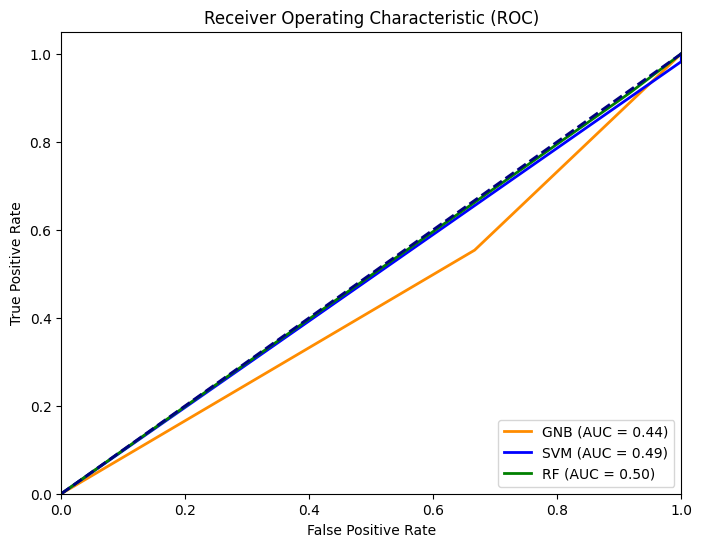

In [ ]:
# Assuming you have selected features and tuned hyperparameters for SVM and Random Forest
# Import necessary libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# Create and train the final models
gnb_final = GaussianNB()
gnb_final.fit(X_train_selected, y_train)  # Use the selected features from Part 5

# Use the best hyperparameters for SVM from Part 3
svm_final = SVC(probability=True, random_state=23655842, **best_params)
svm_final.fit(X_train_selected, y_train)  # Use the selected features from Part 5

# Use the best hyperparameters for Random Forest from Part 4
rf_final = RandomForestClassifier(**best_params_rf)
rf_final.fit(X_train_selected, y_train)  # Use the selected features from Part 5

# Assuming top_12_feature_indices is a list of feature indices you want to select
top_12_feature_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
    # Add the indices of the features you want to select
]

# Get the selected features from X_test using the indices
X_test_selected = X_test[:, top_12_feature_indices]

# Evaluate the final models on the test set
gnb_test_preds = gnb_final.predict(X_test_selected)  # Modify 'X_test_selected' based on your selected features
svm_test_preds = svm_final.predict(X_test_selected)  # Modify 'X_test_selected' based on your selected features
rf_test_preds = rf_final.predict(X_test_selected)  # Modify 'X_test_selected' based on your selected features

# Calculate ROC curves and AUC for each model
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, gnb_test_preds)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_test_preds)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_test_preds)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Rest of your code for plotting and printing metrics remains the same

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_gnb, tpr_gnb, color='darkorange', lw=2, label=f'GNB (AUC = {roc_auc_gnb:.2f})')
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'RF (AUC = {roc_auc_rf:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print and compare mean metrics for final models
gnb_metrics = binary_metrics(y_test, gnb_test_preds)
svm_metrics = binary_metrics


## Part 7: Holdout Set Evaluation (Instructor)

Your final models `gnb_final`, `svm_final`, and `rf_final` will be evaluated on a holdout set by the instructor.